# First, let's import a pre-trained model and prepare the data

In [54]:
import torch

In [208]:
trained_model_path = '../saved_models/SM0-0.pth.tar'

In [209]:
trained_model = torch.load(trained_model_path,map_location=torch.device('cpu'))

In [210]:
from SwinAgeMapper import SwinAgeMapper

In [211]:
model = SwinAgeMapper(
                    img_size = (160,192,160),
                    in_channels = 1,
                    depths = (2, 2, 2, 2),
                    num_heads = (3, 6, 12, 24),
                    feature_size = 24,
                    drop_rate = 0.0,
                    attn_drop_rate = 0.0,
                    dropout_path_rate = 0.0,
                    use_checkpoint = True,
                    spatial_dims = 3,
                    downsample = "merging",
                    fully_connected_activation = "relu",
                    resolution='1mm',
                    )

In [212]:
model.load_state_dict(trained_model)

<All keys matched successfully>

In [213]:
model.eval()

SwinAgeMapper(
  (Upsample): Identity()
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 24, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=24, out_features=72, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=24, out_features=24, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=24, out_features=96, bias=True)
              (linear

In [214]:
for key in model.state_dict().keys():
    print(key, '\n\t', model.state_dict()[key].shape)

swinViT.patch_embed.proj.weight 
	 torch.Size([24, 1, 2, 2, 2])
swinViT.patch_embed.proj.bias 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.norm1.weight 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.norm1.bias 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.attn.relative_position_bias_table 
	 torch.Size([2197, 3])
swinViT.layers1.0.blocks.0.attn.relative_position_index 
	 torch.Size([343, 343])
swinViT.layers1.0.blocks.0.attn.qkv.weight 
	 torch.Size([72, 24])
swinViT.layers1.0.blocks.0.attn.qkv.bias 
	 torch.Size([72])
swinViT.layers1.0.blocks.0.attn.proj.weight 
	 torch.Size([24, 24])
swinViT.layers1.0.blocks.0.attn.proj.bias 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.norm2.weight 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.norm2.bias 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.mlp.linear1.weight 
	 torch.Size([96, 24])
swinViT.layers1.0.blocks.0.mlp.linear1.bias 
	 torch.Size([96])
swinViT.layers1.0.blocks.0.mlp.linear2.weight 
	 torch.Size([24, 96])
swinViT.layers1.0.bl

In [215]:
import nibabel as nib
import numpy as np
import pandas as pd

In [263]:
# X_path = '../../multi-age-mapper/additional_data_examples/24237795/T1_brain_to_MNI.nii.gz'
# X2_path = '../../multi-age-mapper/additional_data_examples/24806531/T1_brain_to_MNI.nii.gz'
scaling_values = '../../../SwinAgeMapper/datasets/scaling_values_simple.csv'
X_path = '24237795'
X2_path = '24806531'

In [286]:
def processs_inputs(modality_flag='T1_nonlinear',
                    subject_path='24237795'
                   ):
    
    scaling_values_simple = pd.read_csv(scaling_values, index_col=0)
    scale_factor = scaling_values_simple.loc[modality_flag].scale_factor
    # resolution = scaling_values_simple.loc[list(modality_flag)].resolution.to_list()
    
    X_path = '../../multi-age-mapper/additional_data_examples/' + subject_path + '/T1_brain_to_MNI.nii.gz'
    X_volume = np.array(nib.load(X_path).dataobj)
    
    crop_values = [10, 170, 12, 204, 0, 160]
    
    X_volume = X_volume[crop_values[0]:crop_values[1],
                        crop_values[2]:crop_values[3], 
                        crop_values[4]:crop_values[5]]
    
    X_volume = X_volume / X_volume.mean()
    
    X_volume = X_volume / scale_factor
    X_volume = torch.from_numpy(X_volume)
    
    return X_volume

In [311]:
X = processs_inputs(subject_path = X_path)

In [312]:
X.shape

torch.Size([160, 192, 160])

In [313]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(-0.5, 191.5, 159.5, -0.5)

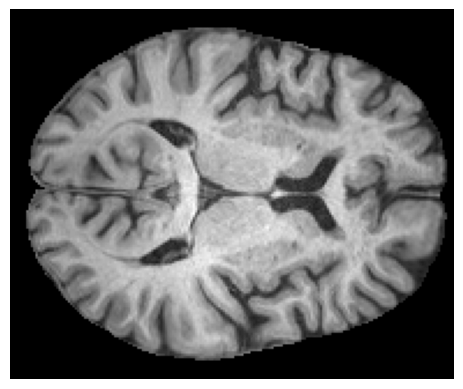

In [221]:
plt.imshow(X[:,:,80], cmap='gray')
plt.grid()
plt.axis('off')

In [222]:
from scipy import ndimage

(-0.5, 159.5, 191.5, -0.5)

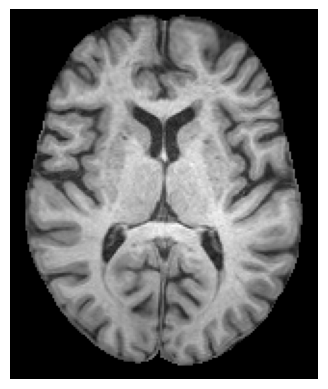

In [223]:
plt.imshow(ndimage.rotate(X[:,:,80], 90), cmap='gray')
plt.grid()
plt.axis('off')

In [314]:
X = torch.unsqueeze(torch.unsqueeze(X, dim=0), dim=0)
X.shape

torch.Size([1, 1, 160, 192, 160])

In [284]:
model(X)

tensor([[76.3136]], grad_fn=<AddmmBackward0>)

In [285]:
y = model(X)

# Let's try to get some attention

In [21]:
def rollout(attentions, discard_ratio, head_fusion):
    # result = torch.eye(attentions[0].size(-1))
    
    results = []
    
    with torch.no_grad():
        for attention in attentions:
            results.append(attention)
            
            print(attention.shape)
            
#             if head_fusion == "mean":
#                 attention_heads_fused = attention.mean(axis=1)
#             elif head_fusion == "max":
#                 attention_heads_fused = attention.max(axis=1)[0]
#             elif head_fusion == "min":
#                 attention_heads_fused = attention.min(axis=1)[0]
#             else:
#                 raise "Attention head fusion type Not supported"

#             # Drop the lowest attentions, but
#             # don't drop the class token
#             flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
#             _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
#             indices = indices[indices != 0]
#             flat[0, indices] = 0

#             I = torch.eye(attention_heads_fused.size(-1))
#             a = (attention_heads_fused + 1.0*I)/2
#             a = a / a.sum(dim=-1)

#             result = torch.matmul(a, result)
    
#     # Look at the total attention between the class token,
#     # and the image patches
#     mask = result[0, 0 , 1 :]
#     # In case of 224x224 image, this brings us from 196 to 14
#     width = int(mask.size(-1)**0.5)
#     mask = mask.reshape(width, width).numpy()
#     mask = mask / np.max(mask)
#     return mask   

    return results

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():

            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [22]:
name = 'swinViT.layers1.0.blocks.0.attn.attn_drop'
'attn_drop' in name

True

In [24]:
head_fusion='max'
discard_ratio = 0.9

In [149]:
print("Doing Attention Rollout")
attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
    discard_ratio=discard_ratio)
mask = attention_rollout(X)
# name = "attention_rollout_{:.3f}_{}.png".format(discard_ratio, head_fusion)

Doing Attention Rollout
torch.Size([2016, 3, 343, 343])
torch.Size([2016, 3, 343, 343])
torch.Size([252, 6, 343, 343])
torch.Size([252, 6, 343, 343])
torch.Size([36, 12, 343, 343])
torch.Size([36, 12, 343, 343])
torch.Size([8, 24, 343, 343])
torch.Size([8, 24, 343, 343])


In [ ]:
# 343 is the equivalent of a 7x7x7 embedding (197)
# 3 are the number of heads (3)
# 2016... are the number of feature representations (64)
# If for every attention head separately, we look inside the dimension with 343 tokens, we can peek at the last 7x7x7=343 tokens.
# This gives us an image of size 7x7x7x2016 which we can then visualize.

In [168]:
len(mask)

8

In [169]:
m1 = mask[-1]

In [170]:
print(m1.shape, m1.min(), m1.max(), m1.mean())

torch.Size([8, 24, 343, 343]) tensor(0.) tensor(0.9339) tensor(0.0029)


In [177]:
m1_fused = m1.max(axis=1)[0]

In [181]:
m1_flat = m1_fused.view(m1_fused.size(0), -1)
m1_flat.shape

torch.Size([8, 117649])

In [182]:
_, indices = m1_flat.topk(int(m1_flat.size(-1)*discard_ratio), -1, False)
indices = indices[indices != 0]
m1_flat[0, indices] = 0

In [183]:
m1_flat.shape

torch.Size([8, 117649])

In [ ]:
# I = torch.eye(attention_heads_fused.size(-1))
# a = (attention_heads_fused + 1.0*I)/2
# a = a / a.sum(dim=-1)

In [315]:
def rollout(attentions, discard_ratio, head_fusion):
    # result = torch.eye(attentions[0].size(-1))
    
    results = []
    results2 = []
    results3 = []
    
    with torch.no_grad():
        for attention in attentions:
            results.append(attention)
            
            print(attention.shape)
            
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            # I = torch.eye(attention_heads_fused.size(-1))
            # a = (attention_heads_fused + 1.0*I)/2
            # a = a / a.sum(dim=-1)

            results3.append(attention_heads_fused)
            # result = torch.matmul(a, result)
            # results2.append(result)
    
    # # Look at the total attention between the class token,
    # # and the image patches
    # mask = result[0, 0 , 1 :]
    # # In case of 224x224 image, this brings us from 196 to 14
    # width = int(mask.size(-1)**0.5)
    # mask = mask.reshape(width, width).numpy()
    # mask = mask / np.max(mask)
    # return mask   

    return results, results2, results3

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean", # attn_drop downsample.norm
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():

            # print(name, attention_layer_name)
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

# drop2

In [316]:
print("Doing Attention Rollout")
attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
    discard_ratio=discard_ratio)
mask, mask2, mask3 = attention_rollout(X)

Doing Attention Rollout


None of the inputs have requires_grad=True. Gradients will be None


torch.Size([2016, 3, 343, 343])
torch.Size([2016, 3, 343, 343])
torch.Size([252, 6, 343, 343])
torch.Size([252, 6, 343, 343])
torch.Size([36, 12, 343, 343])
torch.Size([36, 12, 343, 343])
torch.Size([8, 24, 343, 343])
torch.Size([8, 24, 343, 343])


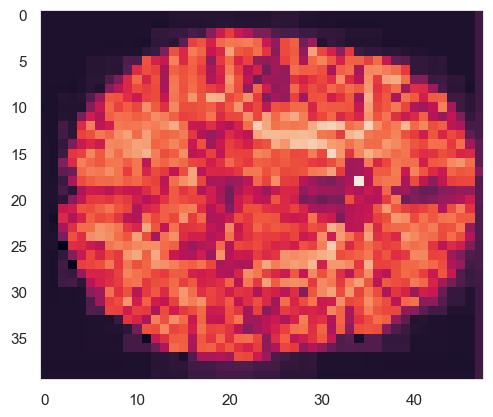

In [43]:
msk = mask[0]
plt.imshow(msk[0,:,:,20,91])
plt.grid()

In [74]:
x = mask[-1]
xfused = x.max(axis=1)[0]

xflat = xfused.view(xfused.size(0), -1)
_, indices = xflat.topk(int(xflat.size(-1)*discard_ratio), -1, False)
indices = indices[indices != 0]
xflat[0, indices] = 0

I = torch.eye(xfused.size(-1))
a = (xfused + 1.0*I)/2
# a = a / a.sum(dim=-1)

In [75]:
a.shape

torch.Size([8, 343, 343])

In [76]:
a.sum(dim=-1).shape

torch.Size([8, 343])

In [77]:
a = a / a.sum(dim=-1)

RuntimeError: The size of tensor a (343) must match the size of tensor b (8) at non-singleton dimension 1

In [83]:
msk = mask3[-1]

In [84]:
width = round(msk.size(-1)**(1/3))

In [120]:
msk2 = msk[4,200,:]


In [121]:
msk.shape

torch.Size([8, 343, 343])

In [122]:
msk2.shape

torch.Size([343])

In [123]:
msk2

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [88]:
msk2 = msk2.reshape(width, width, width)

In [90]:
msk2.shape

torch.Size([7, 7, 7])

In [ ]:
msk

In [85]:
msk2 = cv2.resize(msk2.numpy(), (X.numpy().shape[0], X.numpy().shape[1]))

In [86]:
msk2.shape

(1, 1, 7)

In [87]:
msk2

array([[[0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [317]:
msk1 = mask[2]
msk2 = mask[3]

In [318]:
print(msk1.shape, msk2.shape)

torch.Size([252, 6, 343, 343]) torch.Size([252, 6, 343, 343])


In [319]:
attention_heads_fused1 = msk1.max(axis=1)[0]
attention_heads_fused2 = msk2.max(axis=1)[0]

In [320]:
result = torch.eye(msk1[0].size(-1))

In [321]:
result.shape

torch.Size([343, 343])

In [322]:
I1 = torch.eye(attention_heads_fused1.size(-1))
I2 = torch.eye(attention_heads_fused2.size(-1))

In [323]:
I1.shape

torch.Size([343, 343])

In [324]:
a1 = (attention_heads_fused1 + 1.0*I)/2
a2 = (attention_heads_fused2 + 1.0*I)/2

In [325]:
a1.shape

torch.Size([252, 343, 343])

In [326]:
a1.sum(dim=-1).shape

torch.Size([252, 343])

In [327]:
np.divide(a1, a1.sum(dim=-1))

ValueError: operands could not be broadcast together with shapes (252,343,343) (252,343) 

In [328]:
result = torch.matmul(a1, result)
result = torch.matmul(a2, result)

In [329]:
result.shape

torch.Size([252, 343, 343])

In [380]:
# mask = result[0, 0 , 0 :]
# result.max(axis=0)[0].shape
mask = result.max(axis=0)[0][0]

In [381]:
mask.shape

torch.Size([343])

In [382]:
width = round(mask.size(-1)**0.3333)

In [383]:
width

7

In [384]:
mask = mask.reshape(width, width, width).numpy()

In [385]:
mask.shape

(7, 7, 7)

In [386]:
mask = mask / np.max(mask)

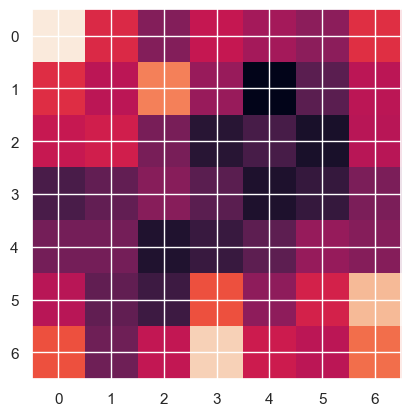

In [387]:
plt.imshow(mask[:,:,3])

In [338]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


np_img = X[:,:,80]


np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)
cv2.imshow("Input Image", np_img)
cv2.imshow(name, mask)

IndexError: too many indices for array: array is 0-dimensional, but 3 were indexed

In [339]:
import cv2

In [340]:
img = X[:,:,80]
mask2 = mask[:,:,4]
mask2 = cv2.resize(mask2, (img.shape[1], img.shape[0]))

In [341]:
mask2.shape

(1, 1)

(-0.5, 191.5, 159.5, -0.5)

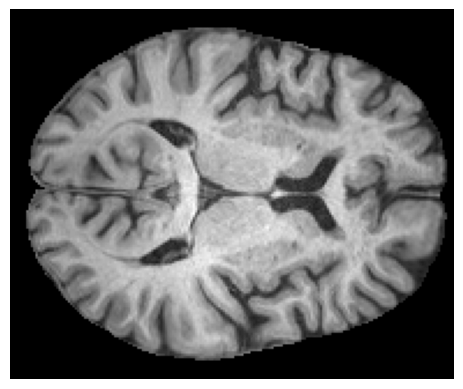

In [272]:
plt.imshow(X[:,:,80], cmap='gray')
plt.grid()
plt.axis('off')

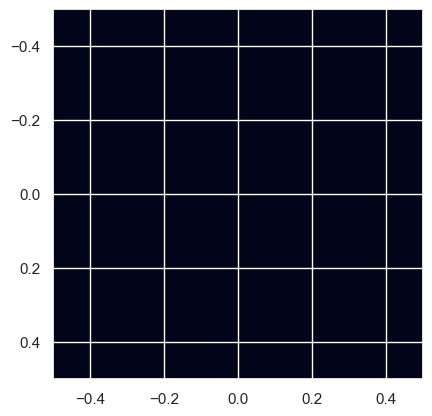

In [342]:
plt.imshow(mask2)

TypeError: Invalid shape (1, 1, 192, 160) for image data

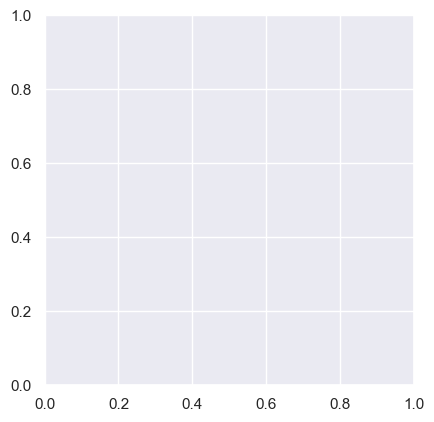

In [345]:
img = X.squeeze()
img = X[:,:,80]

plt.imshow(img)
plt.imshow(mask2, alpha=0.8)
plt.grid()

In [255]:
def show_mask_on_image(img, mask):
    # img = np.float32(img) / 255
    img = np.expand_dims(img, -1).shape
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [275]:
mask2 = show_mask_on_image(img, mask2)

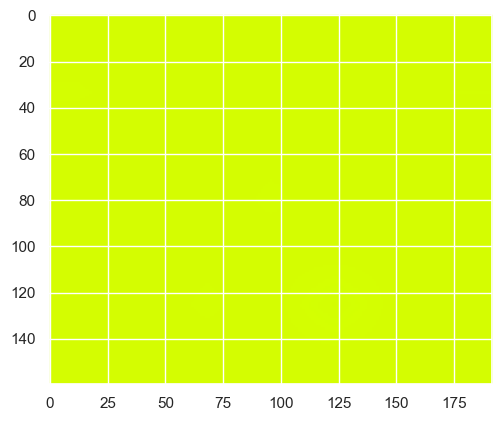

In [276]:
plt.imshow(mask2)

In [388]:
mask.shape

(7, 7, 7)

In [389]:
from scipy.ndimage import zoom
new_mask = zoom(mask, (22.857142857142857, 27.428571428571429, 22.857142857142857))

In [390]:
X.shape

torch.Size([1, 1, 160, 192, 160])

In [391]:
new_mask.shape

(160, 192, 160)

In [392]:
Xtest = torch.squeeze(X)
Xtest.shape

torch.Size([160, 192, 160])

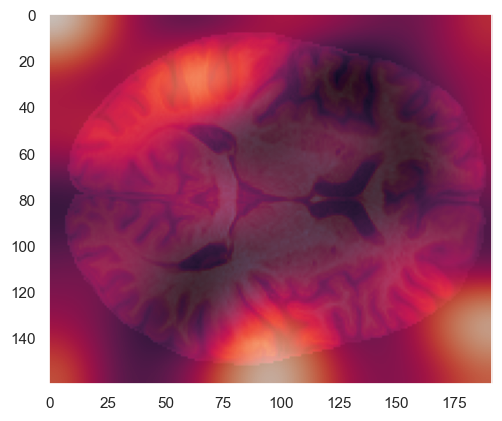

In [394]:
loc = 80
Xtest = torch.squeeze(X)

plt.imshow(Xtest[:,:,loc])
plt.imshow(new_mask[:,:,loc], alpha=0.8)
plt.grid()

In [292]:
nib.save(new_mask, 'mask.nii.gz')

AttributeError: 'numpy.ndarray' object has no attribute 'to_filename'

In [296]:
from fsl.data.image import Image

ModuleNotFoundError: No module named 'fsl'

In [297]:
! pip install fslpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 1.4 MB/s eta 0:00:0000:0100:01


In [298]:
from fsl.data.image import Image

In [349]:
img = Image(new_mask)

In [350]:
img.save('new_mask.nii.gz')

In [351]:
header = Image('../../multi-age-mapper/additional_data_examples/24237795/T1_brain_to_MNI.nii.gz').header
img = Image(new_mask, header=header)
img.save('new_mask.nii.gz')